### Previsão de Mortes Neonatal

Neste projeto, vamos utilizar dados públicos do SINASC (Sistema de Nascidos Vivos) e do SIM (Sistema de Mortalidade) para construir modelos de aprendizado de máquina capazes de prever o risco de morte neonatal (até 28 dias após o nascimento).

*Alunos:*
- Júlia Moraes
- Luiz Eduardo

Imports necessários

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping


#### 1. Tratamentos básico dos dados para ML

##### 1.1 Construindo matriz X e vetor y

In [18]:
df = pd.read_csv('sinasc_balanceado.csv', low_memory=False)

In [20]:
# dados númericos
num_cols = ['idade_mae', 'peso', 'semanas_gestacao', 'num_gestacao',
            'partos_normais', 'partos_cesareos', 'mes_inicio_prenatal', 'qntd_filvivos', 'qntd_filmortos']

# dados ordinais
ord_cols = ['consultas_prenatal', 'indice_kotelchuck', 'escolaridade_mae']

# dados categóricos
cat_cols = ['tipo_gravidez', 'tipo_parto', 'parto_induzido', 'cesarea_antes',
            'racacor_mae', 'racacor_bebe', 'paridade', 'anomalia_identificada',
            'doenca_epidemiologicas', 'doenca_nova',
            'prenatal_inadequado', 'poucas_consultas', 'prenatal_tardio']

In [21]:
# Transformar 9 ou outros ignorados em NaN
df.replace(9, pd.NA, inplace=True)

In [22]:
#Pipeline de pré-processamento

# Numéricas: imputar média e padronizar
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # valores vazios vira média
    ('scaler', StandardScaler()) # normaliza
])

# Ordinais: imputar mais frequente e codificar como dummies
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # valores vazios vira moda
])

# Categóricas: imputar mais frequente e codificar dummies
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # valores vazios vira moda
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # codifica dummies
]) # exemplo: tipo_parto_vaginal, tipo_parto_cesarea recebe 0 ou 1 

# Combinar
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ord', ord_transformer, ord_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [23]:
y = df['obitos_1m']
X = df.drop(columns=['obitos_1m'])

In [24]:
# Verificar valores nulos nas colunas numéricas
print("Valores nulos nas colunas numéricas:")
for col in num_cols:
    if col in X.columns:
        print(f"{col}: {X[col].isnull().sum()}")

# Substituir pd.NA por np.nan para compatibilidade com sklearn
X = X.replace({pd.NA: np.nan})

Valores nulos nas colunas numéricas:
idade_mae: 2
peso: 29
semanas_gestacao: 585
num_gestacao: 1621
partos_normais: 2214
partos_cesareos: 2237
mes_inicio_prenatal: 2220
qntd_filvivos: 1714
qntd_filmortos: 2432


C:\Users\julja\AppData\Local\Temp\ipykernel_1552\1250505372.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({pd.NA: np.nan})


In [25]:
X_processed = preprocessor.fit_transform(X)

##### 1.2 Número de amostras e parametros 

In [26]:
N, p = X_processed.shape

print(f"Número de amostras (N): {N}")
print(f"Número de parâmetros (p): {p}")

Número de amostras (N): 44958
Número de parâmetros (p): 46


##### 1.3 Separar em treino e teste

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### 2. REDES NEURAIS

In [29]:
BATCH_SIZE = 32
EPOCHS = 100
RANDOM_STATE = 2

In [30]:
# Criando a arquitetura da rede neural
model = Sequential()


model.add(Dense(64, input_dim=46, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(16,kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1,kernel_initializer='he_normal', activation='sigmoid'))

# Instanciação e configuração de otimizadores
sgd = optimizers.SGD(learning_rate=0.01)

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

c:\Users\julja\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,633 (22.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
history = model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE)

Epoch 1/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7259 - loss: 0.5228
Epoch 2/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7717 - loss: 0.4503
Epoch 3/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7767 - loss: 0.4395
Epoch 4/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7800 - loss: 0.4360
Epoch 5/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7795 - loss: 0.4351
Epoch 6/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7823 - loss: 0.4333
Epoch 7/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7838 - loss: 0.4323
Epoch 8/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7824 - loss: 0.4312
Epoch 9/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7856 - loss: 0.4300
Epoch 10/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7841 - loss: 0.4294
Epoch 11/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7832 - loss: 0.4283
Epoch 12/100
843/843 ━━━━━━━━━━━━━━━━━━━

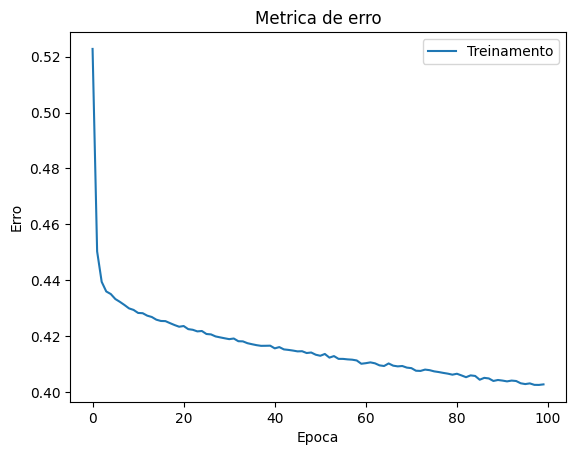


--> Acuracia (treino): 0.8064


In [33]:
from sklearn.metrics import accuracy_score

plt.plot(history.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')


In [34]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=BATCH_SIZE)

Epoch 1/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8038 - loss: 0.4029 - val_accuracy: 0.7903 - val_loss: 0.4222
Epoch 2/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8053 - loss: 0.4018 - val_accuracy: 0.7904 - val_loss: 0.4211
Epoch 3/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8050 - loss: 0.4018 - val_accuracy: 0.7911 - val_loss: 0.4229
Epoch 4/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8041 - loss: 0.4015 - val_accuracy: 0.7923 - val_loss: 0.4210
Epoch 5/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8046 - loss: 0.4016 - val_accuracy: 0.7871 - val_loss: 0.4264
Epoch 6/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8062 - loss: 0.4012 - val_accuracy: 0.7920 - val_loss: 0.4215
Epoch 7/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8051 - loss: 0.4008 - val_accuracy: 0.7920 - val_loss: 0.4235
Epoch 8/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8056 - loss: 0.4009 - val_accu

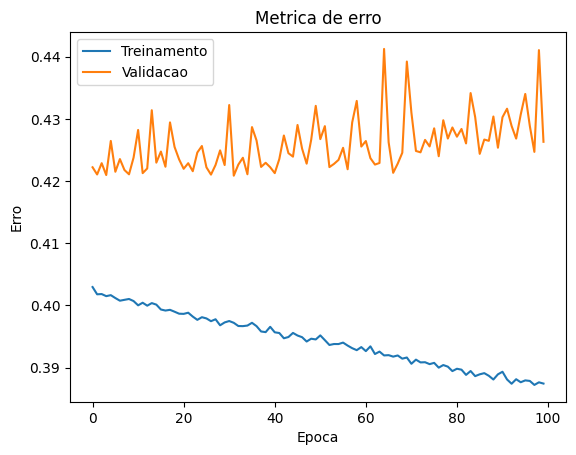

--> E_val - E_in = 0.0453
--> Acuracia (treino): 0.8189
--> Acuracia (validacao): 0.7916
--> acc_train - acc_val = 0.0273


In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de validacao
E_val, acc_val = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print(f"--> E_val - E_in = {E_val - E_in:.4f}")
print(f'--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")

In [46]:
# Converter para arrays NumPy
X_train_np = np.array(X_train)
X_val_np = np.array(X_val)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train_np, y_train_np, validation_data=(X_val_np, y_val_np), epochs=200, batch_size=BATCH_SIZE, callbacks=[es])

Epoch 1/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7853 - loss: 0.4388 - val_accuracy: 0.7903 - val_loss: 0.4330
Epoch 2/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7868 - loss: 0.4377 - val_accuracy: 0.7788 - val_loss: 0.4431
Epoch 3/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7875 - loss: 0.4377 - val_accuracy: 0.7855 - val_loss: 0.4407
Epoch 4/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7880 - loss: 0.4372 - val_accuracy: 0.7894 - val_loss: 0.4385
Epoch 5/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7860 - loss: 0.4381 - val_accuracy: 0.7874 - val_loss: 0.4371
Epoch 6/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7853 - loss: 0.4392 - val_accuracy: 0.7897 - val_loss: 0.4357
Epoch 7/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7853 - loss: 0.4393 - val_accuracy: 0.7888 - val_loss: 0.4336
Epoch 8/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7837 - loss: 0.4383 - val_accu

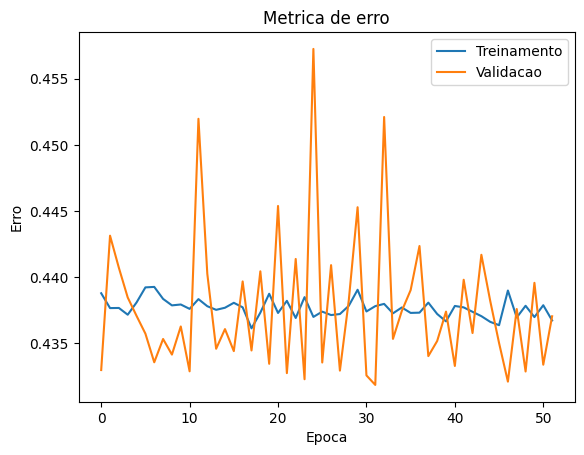

--> E_val - E_in = -0.0001
--> Acuracia (treino): 0.7893
--> Acuracia (validacao): 0.7917
--> acc_train - acc_val = -0.0024


In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train_np, y_train_np, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de validacao
E_val, acc_val = model.evaluate(X_val_np, y_val_np, batch_size=BATCH_SIZE, verbose=0)

print(f"--> E_val - E_in = {E_val - E_in:.4f}")
print(f'--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")

c:\Users\julja\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


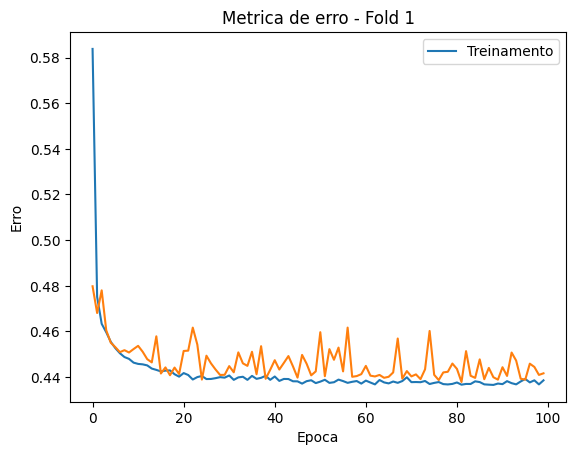

--> Acuracia (treino): 0.7871
--> Acuracia (validacao): 0.7844
--> E_val - E_in = 0.0060
--> acc_in - acc_val = 0.0026



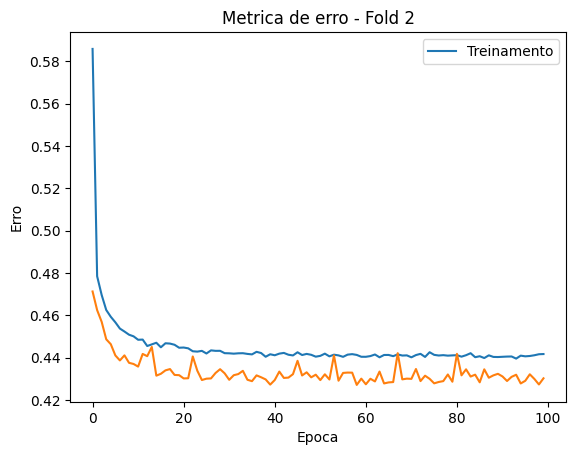

--> Acuracia (treino): 0.7853
--> Acuracia (validacao): 0.7917
--> E_val - E_in = -0.0082
--> acc_in - acc_val = -0.0064



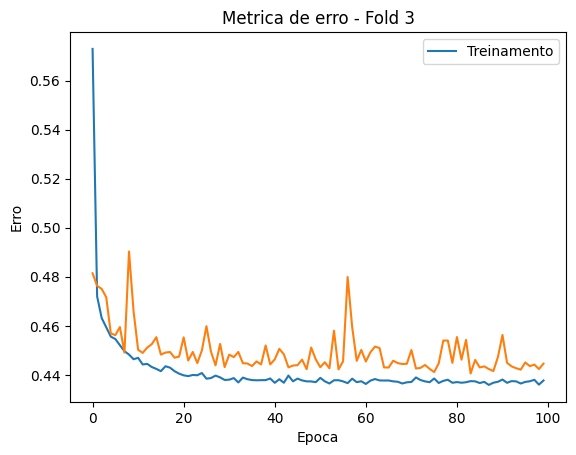

--> Acuracia (treino): 0.7882
--> Acuracia (validacao): 0.7815
--> E_val - E_in = 0.0086
--> acc_in - acc_val = 0.0067



KeyboardInterrupt: 

In [52]:
# Garante o balanceamento nos folds
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

accuracies_train = []
accuracies_val = []
history_list = []
ein_list = []
eval_list = []

# Converter y_train para numpy array
y_train_array = y_train.values

# Realiza o k-fold cross validation
i = 0
for train_index, val_index in skf.split(X_train, y_train):
    i = i + 1
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    # Criando a arquitetura da rede neural    
    model = Sequential()
    model.add(Dense(200, input_dim=p, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dense(200, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))


    # Compilar o modelo
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
  
    # Treina o modelo
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=100, batch_size=BATCH_SIZE, verbose=0)
    history_list.append(history) 
    
    # Avalia o modelo
    E_in, accuracy_train = model.evaluate(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, verbose=0)
    E_val, accuracy_val = model.evaluate(X_val_fold, y_val_fold, batch_size=BATCH_SIZE, verbose=0)
    accuracies_train.append(accuracy_train)
    accuracies_val.append(accuracy_val)
    ein_list.append(E_in)
    eval_list.append(E_val)    
    
    # Exibe o historico de treinamento para um fold especifico
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Metrica de erro - Fold {i}')
    plt.ylabel('Erro')
    plt.xlabel('Epoca')
    plt.legend(['Treinamento'])
    plt.show()

    print(f'--> Acuracia (treino): {accuracy_train:.4f}')
    print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
    print(f"--> E_val - E_in = {E_val - E_in:.4f}")
    print(f"--> acc_in - acc_val = {accuracy_train - accuracy_val:.4f}\n")    

# Calcula a acuracia media
avg_accuracy_train = np.mean(accuracies_train)
avg_accuracy_val = np.mean(accuracies_val)
avg_ein = np.mean(ein_list)
avg_eval = np.mean(eval_list)

# Historico com valores medios dos folds
history_loss_avg = []
history_val_loss_avg = []
aux_list1 = []
aux_list2 = []

for i in range(len(history.history['loss'])):
    for j in range(len(history_list)):
        aux_list1.append(history_list[j].history['loss'][i])
        aux_list2.append(history_list[j].history['val_loss'][i])
    history_loss_avg.append(np.mean(aux_list1))
    history_val_loss_avg.append(np.mean(aux_list2))                            
                   
plt.plot(history_loss_avg)
plt.plot(history_val_loss_avg)
plt.title('Metrica de erro - Media dos Folds')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

print(f'--> Acuracia (treino): {avg_accuracy_train:.4f}')
print(f'--> Acuracia (validacao): {avg_accuracy_val:.4f}')
print(f"--> E_val - E_in = {avg_eval - avg_ein:.4f}")
print(f"--> acc_in - acc_val = {avg_accuracy_train - avg_accuracy_val:.4f}\n")   